<a><img src="https://www.eafit.edu.co/SiteCollectionImages/logo.png" width="350" align="center"></a>
<h1 align="center"><font size="6">Trabajo 2: Preparación de texto, representación de características y representación de documentos.</font></h1>

<hr style="border:2px solid #004B85"> </hr>

# Almacenamiento y Recuperación de la Información
# Maestría en ciencia de los datos y analítica
## 8/03/2021
## Equipo
- Eliana Marcela Sierra Buriticá
- Daniel Romero Cardona
- Camilo Rivera Bedoya
- Juan David Correa Restrepo
- Jose Ignacio Escobar Bedoya

<hr style="border:2px solid #004B85"> </hr>

<h1 align="center"><font size="6">Tabla de Contenidos</font></h1>

1. [Objetivos](#objetivos)
2. [Librerias y variables iniciales](#libre)
3. [Datos](#datos)
4. [Metodologia A](#met_a)
    1. [Tokenización](#a_token)
    2. [Remoción de caracteres especiales](#a_remo_car)
    3. [Stopwords and Words](#a_stwd)
    4. [Stemming](#a_stem)
    5. [Lemmatization](#a_lemma)
    6. [Tokenización en ngrams ](#a_token_ng)
5. [Metodologia B](#met_b)
    1. [Tokenización](#b_token)
    2. [Remoción de caracteres especiales](#b_remo_car)
    3. [Stopwords](#b_stwd)
    4. [Stemming](#b_stem)
    5. [Lemmatization](#b_lemma)
    6. [Tokenización en ngrams ](#b_token_ng)
6. [Metodologia C](#met_c)
    1. [Tokenización](#c_token)
    2. [Remoción de caracteres especiales](#c_remo_car)
    3. [Stopwords](#c_stwd)
    4. [Stemming](#c_stem)
    5. [Lemmatization](#c_lemma)
    6. [Tokenización en ngrams ](#c_token_ng)
7. [Representación de características y de documentos](#repre)
    1. [rank_bm25](#bm25)
    2. [Scikit-Learn](#sk)
    3. [Gensim](#gensim)
    4. [pySpark](#pyspark)
    5. [Metapy](#metapy)
8. [Otros Ejemplos](#otros)
9. [Criterios de evaluación](#crit_eval)

<hr style="border:2px solid #004B85"> </hr>

<a name="objetivos"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">1. Objetivos</font></h1>
<hr style="border:1px solid black"> </hr>

- Hallar el BoW más optimizado posible para un corpus, Realizar la representación de características y de documentos en diferentes librerías.
- Aprender y aplicar diferentes librerías para tokenización y preparación de datos, de tal manera que el estudiante sea consciente de los procesos de preparación de textos como tokenización, remoción de stopwords, remoción/reemplazo de caracteres especiales, procesos de de stemming y lemmatization.
- Aprender y aplicar diferentes técnicas de representación de características como one-bit encoding, TF, TF-IDF, BM25.
- Aprender y aplicar diferentes técnicas de representación de documentos, principalmente en Modelo de Espacio Vectorial (VSM) y opcionalmente doc2vec.
- Aprender diferentes librerías en Python para realizar preparación de texto como NLTK, Spark y META.

<a name="libre"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">2. Librerias, Funciones y variables iniciales</font></h1>
<hr style="border:1px solid black"> </hr>

In [1]:
import findspark
findspark.init('C:\\Users\\Usuario\\Documents\\spark\\spark-3.1.1-bin-hadoop2.7')
import pandas as pd
import numpy as np
import re
import codecs
import matplotlib
import matplotlib.pyplot as plt
import nltk
import os
from termcolor import colored
from nltk.corpus import stopwords
from nltk.corpus import words as voc_en
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from nltk import word_tokenize
import metapy
import pyspark
from pyspark import SparkContext
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim import corpora
from gensim.summarization import bm25 as bm25_gensim #name changed to avoid problems with other libraries
from rank_bm25 import BM25Okapi


# customize matplotlib to include math symbols in the dictionary
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'stixgeneral',
        'mathtext.fontset': 'stix',
    }
)

In [2]:
def graph(tokens):
    ''' Function that graphs the top 20 tokens
        repeated given a list of tokens.
        
        Parameters:
        -----------
        tokens: list of tokens already processed.
    '''
    fdist = nltk.FreqDist(tokens)
    topwords = fdist.most_common(20)
    print(colored('BOW size = ', 'red'),len(fdist))
    x,y = zip(*topwords)
    plt.figure(figsize=(15,4))
    plt.bar(x,y, color = "#004B85")
    plt.xticks(rotation=90, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Top 20 tokens', fontsize=35)
    plt.show()
    return

In [3]:
# input and output folders
path_in="../Datasets/"
path_out="../Output/"

<a name="datos"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">3. Datos</font></h1>

Tomar como base el conjunto de documentos *.txt así como el archivo papers-dc.xml que se encuentran en el siguiente [Github](https://github.com/st1800eafit/st1800_20211/tree/main/datasets/papers_sample_pdf)
<hr style="border:1px solid black"> </hr>

In [4]:
#List of documents in the dataset folder
files = []
i = 1
print(colored('List of available Text files:','blue'))
for file in os.listdir(path_in):
    if file.endswith(".txt"):
        files.append(file)
        print(str(i) + '. ' + file)
        i += 1
files.append('Todos')
print(str(i) + '. Todos')

List of available Text files:
1. 0704.3504.txt
2. 0706.1402.txt
3. 0710.0736.txt
4. 0803.2570.txt
5. 0808.0084.txt
6. 0811.1254.txt
7. 0811.2853.txt
8. 0812.2709.txt
9. Todos


In [5]:
#the user select the document to work with
file_num = 0
while file_num <= 0 or file_num > len(files):
    file_num = input('Ingrese el numero del documento con el que desea trabajar: ')
    try:
        file_num = int(file_num)
        if file_num <= 0 or file_num > len(files):
            print('Error: seleccione un numero de la lista.')
    except:
        print('Error: el valor ingresado no corresponde al formato de un numero entero.')
        file_num = 0
print(colored( 'Selecciono el documento: ', 'blue' ) + files[file_num - 1] )

Ingrese el numero del documento con el que desea trabajar: 9
Selecciono el documento: Todos


In [6]:
# place selected file(s) in a list
filedata = []
if files[file_num - 1] != "Todos":
    input_file = open(path_in + files[file_num - 1], "r", encoding='iso-8859-1')
    filedata.append(input_file.read())
else:
    files = files[:-1]
    for file in files:
        input_file = open(path_in + file, "r", encoding='iso-8859-1')
        filedata.append(input_file.read())

<a name="met_a"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">4. Metodologia A</font></h1>
<h1 align="center"><font size="5">Python, nltk, scikit y/o gensim</font></h1>
<hr style="border:1px solid black"> </hr>

## 4.1. Tokenización <a name="a_token"></a>

BOW size =  18022


C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)


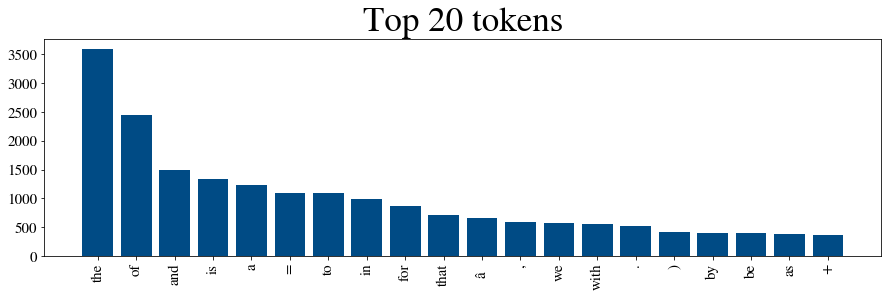

In [7]:
tokens_list = []
for fdata in filedata:
    # Option 1
    tokens1 = fdata.split()
    # option 2
    tokens2 = fdata.split(' ')
    # option 3
    tokens3= nltk.word_tokenize(fdata)
    tokens_list.append(min([tokens1,tokens2,tokens3], key=len)) #preserve the one with less tokens
all_tokens = [j for i in tokens_list for j in i] #join all tokens from the documents

# Graph top 20 tokens
graph(all_tokens)

In [8]:
pd.DataFrame(tokens_list) #show df of tokens for each documents

,0,1,2,3,4,5,6,7,8,9,...,22046,22047,22048,22049,22050,22051,22052,22053,22054,22055
0,Smooth,ReÌnyi,Entropy,of,Ergodic,Quantum\nInformation,Sources\nBerry,Schoenmakers\n\nJilles,Tjoelker\n\narXiv:0704.3504v1,[quant-ph],...,None,None,None,None,None,None,None,None,None,None
1,Analyzing,Design,Process,and,Experiments,on,the\nAnITA,Generic,Tutoring,System\nMatthias,...,None,None,None,None,None,None,None,None,None,None
2,1\n\nColour,Image,Segmentation,by,the\nVector-valued,Allen-Cahn,Phase-field,Model:,a\nMultigrid,Solution\narXiv:0710.0736v1,...,None,None,None,None,None,None,None,None,None,None
3,1\n\nUnequal,Error,Protection:\nAn,Information,Theoretic,Perspective\n\narXiv:0803.2570v4,[cs.IT],25,Oct,2009\n\nShashi,...,channels,with,noiseless,feedback.\nIEEE,Transactions,on,Information,"Theory,","25(6):729â733,",1979.\n\n
4,On,the,hitting,times,of,quantum,versus,random,walks,â\n\narXiv:0808.0084v1,...,None,None,None,None,None,None,None,None,None,None
5,arXiv:0811.1254v1,[math.CO],8,Nov,2008\n\nChapter,1\nCoding,theory,and,algebraic,combinatorics\n\nMichael,...,None,None,None,None,None,None,None,None,None,None
6,Generating,Random,Networks,Without,Short,Cycles\nMohsen,Bayati\nGraduate,School,of,"Business,",...,None,None,None,None,None,None,None,None,None,None
7,1\n\nVariations,on,a,theme,by,Schalkwijk,and,Kailath\nRobert,G.,Gallager\n\nBarÄ±sÌ§,...,None,None,None,None,None,None,None,None,None,None


## 4.2. Remoción de caracteres especiales <a name="a_remo_car"></a>
se quitan los caracteres especiales y adicionalmente se pasa todas las palabras a minusculas

BOW size =  17238


C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\si

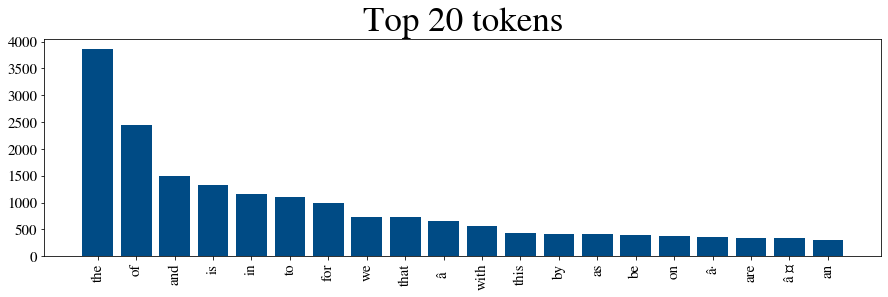

In [9]:
i = 0
for tokens in tokens_list:
    tokens_list[i] = [re.sub(r'[^A-Za-z0-9]+','',w) for w in tokens]
    tokens_list[i] = [w.lower() for w in tokens if len(w)>1]
    i +=1
all_tokens = [j for i in tokens_list for j in i]
graph(all_tokens)

In [10]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,19619,19620,19621,19622,19623,19624,19625,19626,19627,19628
0,smooth,reìnyi,entropy,of,ergodic,quantum\ninformation,sources\nberry,schoenmakers\n\njilles,tjoelker\n\narxiv:0704.3504v1,[quant-ph],...,None,None,None,None,None,None,None,None,None,None
1,analyzing,design,process,and,experiments,on,the\nanita,generic,tutoring,system\nmatthias,...,None,None,None,None,None,None,None,None,None,None
2,1\n\ncolour,image,segmentation,by,the\nvector-valued,allen-cahn,phase-field,model:,a\nmultigrid,solution\narxiv:0710.0736v1,...,None,None,None,None,None,None,None,None,None,None
3,1\n\nunequal,error,protection:\nan,information,theoretic,perspective\n\narxiv:0803.2570v4,[cs.it],25,oct,2009\n\nshashi,...,channels,with,noiseless,feedback.\nieee,transactions,on,information,"theory,","25(6):729â733,",1979.\n\n
4,on,the,hitting,times,of,quantum,versus,random,walks,â\n\narxiv:0808.0084v1,...,None,None,None,None,None,None,None,None,None,None
5,arxiv:0811.1254v1,[math.co],nov,2008\n\nchapter,1\ncoding,theory,and,algebraic,combinatorics\n\nmichael,huberâ\ninstitut,...,None,None,None,None,None,None,None,None,None,None
6,generating,random,networks,without,short,cycles\nmohsen,bayati\ngraduate,school,of,"business,",...,None,None,None,None,None,None,None,None,None,None
7,1\n\nvariations,on,theme,by,schalkwijk,and,kailath\nrobert,g.,gallager\n\nbarä±sì§,nakibogìlu\n\narxiv:0812.2709v4,...,None,None,None,None,None,None,None,None,None,None


## 4.3. Stopwords and Words <a name="a_stwd"></a>

In [11]:
stop_words_nltk = set(stopwords.words('english'))
print(len(stop_words_nltk))

179


BOW size =  17132


C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\si

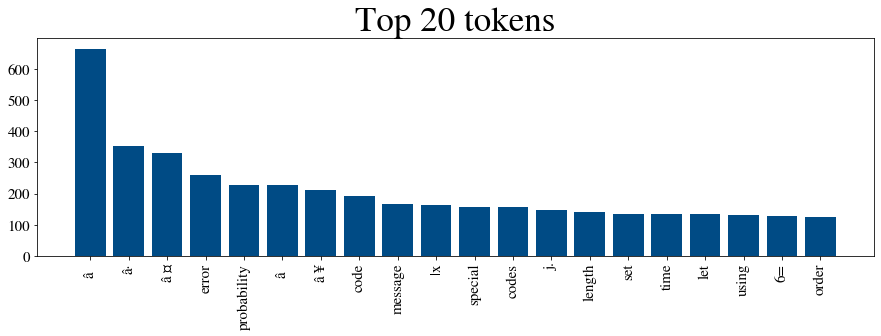

In [12]:
i = 0
for tokens in tokens_list:
    tokens_list[i] = [w for w in tokens if w not in stop_words_nltk]
    i += 1
all_tokens = [j for i in tokens_list for j in i]
graph(all_tokens)

In [13]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,14179,14180,14181,14182,14183,14184,14185,14186,14187,14188
0,smooth,reìnyi,entropy,ergodic,quantum\ninformation,sources\nberry,schoenmakers\n\njilles,tjoelker\n\narxiv:0704.3504v1,[quant-ph],26,...,None,None,None,None,None,None,None,None,None,None
1,analyzing,design,process,experiments,the\nanita,generic,tutoring,system\nmatthias,r.,brust\nfaculty,...,None,None,None,None,None,None,None,None,None,None
2,1\n\ncolour,image,segmentation,the\nvector-valued,allen-cahn,phase-field,model:,a\nmultigrid,solution\narxiv:0710.0736v1,[cs.cv],...,None,None,None,None,None,None,None,None,None,None
3,1\n\nunequal,error,protection:\nan,information,theoretic,perspective\n\narxiv:0803.2570v4,[cs.it],25,oct,2009\n\nshashi,...,schalkwijk-barron,scheme,channels,noiseless,feedback.\nieee,transactions,information,"theory,","25(6):729â733,",1979.\n\n
4,hitting,times,quantum,versus,random,walks,â\n\narxiv:0808.0084v1,[quant-ph],aug,2008\n\nfreìdeìric,...,None,None,None,None,None,None,None,None,None,None
5,arxiv:0811.1254v1,[math.co],nov,2008\n\nchapter,1\ncoding,theory,algebraic,combinatorics\n\nmichael,huberâ\ninstitut,fuìr,...,None,None,None,None,None,None,None,None,None,None
6,generating,random,networks,without,short,cycles\nmohsen,bayati\ngraduate,school,"business,",stanford,...,None,None,None,None,None,None,None,None,None,None
7,1\n\nvariations,theme,schalkwijk,kailath\nrobert,g.,gallager\n\nbarä±sì§,nakibogìlu\n\narxiv:0812.2709v4,[cs.it],20,nov,...,None,None,None,None,None,None,None,None,None,None


BOW size =  2144


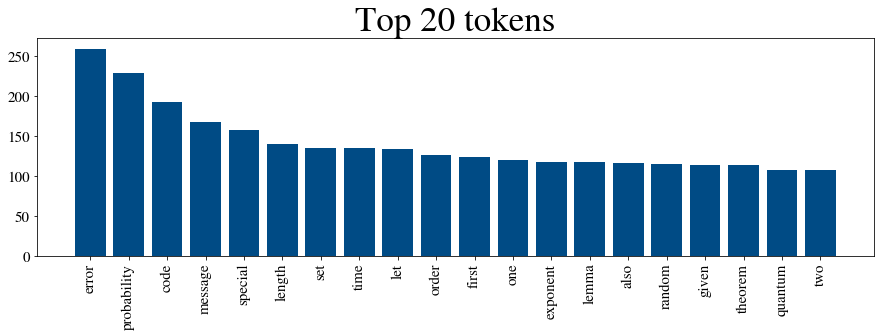

In [14]:
# take only the word that exist in the dictionary
x = voc_en.words()
i = 0
for tokens in tokens_list:
    tokens_list[i] = [w for w in tokens if w in x]
    i += 1
all_tokens = [j for i in tokens_list for j in i]
graph(all_tokens)

In [15]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982
0,smooth,entropy,ergodic,mathematics,computer,university,security,research,signal,research,...,None,None,None,None,None,None,None,None,None,None
1,design,process,generic,technology,university,technology,university,field,many,specific,...,None,None,None,None,None,None,None,None,None,None
2,image,segmentation,propose,new,method,numerical,solution,model,colour,give,...,None,None,None,None,None,None,None,None,None,None
3,error,information,theoretic,institute,information,theoretic,framework,unequal,error,protection,...,error,protection,information,international,symposium,asymptotic,performance,scheme,noiseless,information
4,times,quantum,versus,random,time,classical,random,walk,time,detect,...,None,None,None,None,None,None,None,None,None,None
5,theory,algebraic,chapter,fruitful,interplay,algebraic,focus,interaction,combinatorial,finite,...,None,None,None,None,None,None,None,None,None,None
6,generating,random,without,short,school,ca,electrical,engineering,ca,management,...,None,None,None,None,None,None,None,None,None,None
7,theme,class,block,ideal,probability,error,exponent,block,length,surprising,...,None,None,None,None,None,None,None,None,None,None


## 4.4. Stemming <a name="a_stem"></a>

BOW size =  1701


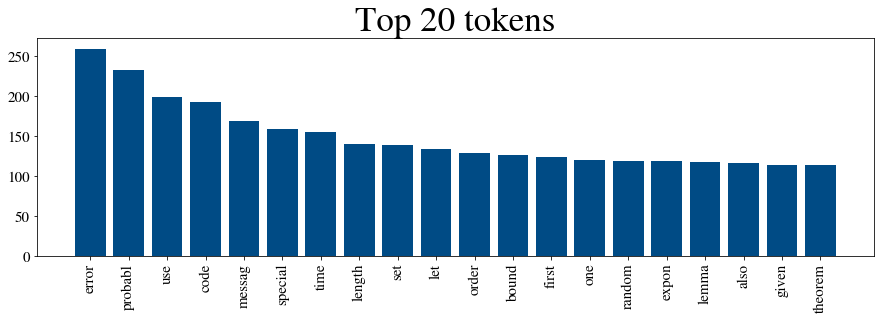

In [16]:
#define 3 diferent stemmers
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer("english")
tokens_list1 = tokens_list.copy() #made a copy of the list of tokens to do stemming
i = 0
for tokens in tokens_list1:
    # Option 1 
    tokens1 = [porter.stem(w) for w in tokens]
    # Option 2
    tokens2 = [lancaster.stem(w) for w in tokens]
    # Option 3
    tokens3 = [snowball.stem(w) for w in tokens]
    tokens_list1[i] = min([tokens1,tokens2,tokens3], key=len) # preserve the one with less tokens
    i += 1
all_tokens_st = [j for i in tokens_list1 for j in i] # join all tokens from all documents
# Graph top 20 tokens
graph(all_tokens_st)

In [17]:
pd.DataFrame(tokens_list1)

,0,1,2,3,4,5,6,7,8,9,...,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982
0,smooth,entropi,ergod,mathemat,comput,univers,secur,research,signal,research,...,None,None,None,None,None,None,None,None,None,None
1,design,process,gener,technolog,univers,technolog,univers,field,mani,specif,...,None,None,None,None,None,None,None,None,None,None
2,imag,segment,propos,new,method,numer,solut,model,colour,give,...,None,None,None,None,None,None,None,None,None,None
3,error,inform,theoret,institut,inform,theoret,framework,unequ,error,protect,...,error,protect,inform,intern,symposium,asymptot,perform,scheme,noiseless,inform
4,time,quantum,versu,random,time,classic,random,walk,time,detect,...,None,None,None,None,None,None,None,None,None,None
5,theori,algebra,chapter,fruit,interplay,algebra,focu,interact,combinatori,finit,...,None,None,None,None,None,None,None,None,None,None
6,gener,random,without,short,school,ca,electr,engin,ca,manag,...,None,None,None,None,None,None,None,None,None,None
7,theme,class,block,ideal,probabl,error,expon,block,length,surpris,...,None,None,None,None,None,None,None,None,None,None


## 4.5. Lemmatization <a name="a_lemma"></a>

BOW size =  1941


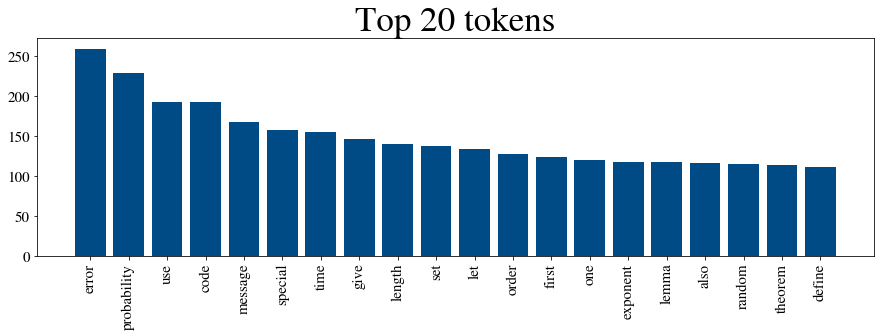

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()
tokens_list2 = tokens_list.copy()
i = 0
for tokens in tokens_list2:
    tokens1 = [wordnet_lemmatizer.lemmatize(w, pos="v") for w in tokens ]
    tokens2 = [wordnet_lemmatizer.lemmatize(w) for w in tokens ]
    tokens_list2[i] = min([tokens1,tokens2], key=len)
    i += 1
all_tokens_lm = [j for i in tokens_list2 for j in i]
graph(all_tokens_lm)

In [19]:
pd.DataFrame(tokens_list2)

,0,1,2,3,4,5,6,7,8,9,...,4973,4974,4975,4976,4977,4978,4979,4980,4981,4982
0,smooth,entropy,ergodic,mathematics,computer,university,security,research,signal,research,...,None,None,None,None,None,None,None,None,None,None
1,design,process,generic,technology,university,technology,university,field,many,specific,...,None,None,None,None,None,None,None,None,None,None
2,image,segmentation,propose,new,method,numerical,solution,model,colour,give,...,None,None,None,None,None,None,None,None,None,None
3,error,information,theoretic,institute,information,theoretic,framework,unequal,error,protection,...,error,protection,information,international,symposium,asymptotic,performance,scheme,noiseless,information
4,time,quantum,versus,random,time,classical,random,walk,time,detect,...,None,None,None,None,None,None,None,None,None,None
5,theory,algebraic,chapter,fruitful,interplay,algebraic,focus,interaction,combinatorial,finite,...,None,None,None,None,None,None,None,None,None,None
6,generate,random,without,short,school,ca,electrical,engineer,ca,management,...,None,None,None,None,None,None,None,None,None,None
7,theme,class,block,ideal,probability,error,exponent,block,length,surprise,...,None,None,None,None,None,None,None,None,None,None


## 4.6. Tokenización en ngrams  <a name="a_token_ng"></a>

In [20]:
#take the best result between stemming y lemmatization
if len(all_tokens_lm) < len(all_tokens_st): tokens_list = tokens_list2.copy()
else: tokens_list = tokens_list1.copy()

In [21]:
i = 0
tokens_list1 = tokens_list.copy()
for tokens in tokens_list1:
    tokens_list1[i] = list(nltk.ngrams(tokens,2))
    i += 1
all_tokens = [j for i in tokens_list1 for j in i]
print('Bigrams: ' ,len(all_tokens))
all_tokens

Bigrams:  17700


[('smooth', 'entropi'),
 ('entropi', 'ergod'),
 ('ergod', 'mathemat'),
 ('mathemat', 'comput'),
 ('comput', 'univers'),
 ('univers', 'secur'),
 ('secur', 'research'),
 ('research', 'signal'),
 ('signal', 'research'),
 ('research', 'investig'),
 ('investig', 'recent'),
 ('recent', 'notion'),
 ('notion', 'entropi'),
 ('entropi', 'case'),
 ('case', 'ergod'),
 ('ergod', 'inform'),
 ('inform', 'previou'),
 ('previou', 'work'),
 ('work', 'concentr'),
 ('concentr', 'inform'),
 ('inform', 'actual'),
 ('actual', 'consid'),
 ('consid', 'inform'),
 ('inform', 'ergod'),
 ('ergod', 'classic'),
 ('classic', 'inform'),
 ('inform', 'special'),
 ('special', 'prove'),
 ('prove', 'entropi'),
 ('entropi', 'rate'),
 ('rate', 'approach'),
 ('approach', 'entropi'),
 ('entropi', 'rate'),
 ('rate', 'ergod'),
 ('ergod', 'equal'),
 ('equal', 'classic'),
 ('classic', 'sourc'),
 ('sourc', 'entropi'),
 ('entropi', 'quantum'),
 ('quantum', 'eleg'),
 ('eleg', 'notion'),
 ('notion', 'smooth'),
 ('smooth', 'entropi'),


In [22]:
i = 0
tokens_list2 = tokens_list.copy()
for tokens in tokens_list2:
    tokens_list2[i] = list(nltk.ngrams(tokens,3))
    i += 1
all_tokens = [j for i in tokens_list2 for j in i]
print('trigrams: ', len(all_tokens))
all_tokens

trigrams:  17692


[('smooth', 'entropi', 'ergod'),
 ('entropi', 'ergod', 'mathemat'),
 ('ergod', 'mathemat', 'comput'),
 ('mathemat', 'comput', 'univers'),
 ('comput', 'univers', 'secur'),
 ('univers', 'secur', 'research'),
 ('secur', 'research', 'signal'),
 ('research', 'signal', 'research'),
 ('signal', 'research', 'investig'),
 ('research', 'investig', 'recent'),
 ('investig', 'recent', 'notion'),
 ('recent', 'notion', 'entropi'),
 ('notion', 'entropi', 'case'),
 ('entropi', 'case', 'ergod'),
 ('case', 'ergod', 'inform'),
 ('ergod', 'inform', 'previou'),
 ('inform', 'previou', 'work'),
 ('previou', 'work', 'concentr'),
 ('work', 'concentr', 'inform'),
 ('concentr', 'inform', 'actual'),
 ('inform', 'actual', 'consid'),
 ('actual', 'consid', 'inform'),
 ('consid', 'inform', 'ergod'),
 ('inform', 'ergod', 'classic'),
 ('ergod', 'classic', 'inform'),
 ('classic', 'inform', 'special'),
 ('inform', 'special', 'prove'),
 ('special', 'prove', 'entropi'),
 ('prove', 'entropi', 'rate'),
 ('entropi', 'rate', 'a

<a name="met_b"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">5. Metodologia B</font></h1>
<h1 align="center"><font size="5">PySpark con Spark</font></h1>
<hr style="border:1px solid black"> </hr>

## 5.1. Tokenización <a name="b_token"></a>

## 5.2. Remoción de caracteres especiales <a name="b_remo_car"></a>

## 5.3. Stopwords <a name="b_stwd"></a>

## 5.4. Stemming <a name="b_stem"></a>

## 5.5. Lemmatization <a name="b_lemma"></a>

## 5.6. Tokenización en ngrams  <a name="b_token_ng"></a>

<a name="met_c"><hr style="border:1px solid black"> </hr>
</a><h1 align="center"><font size="6">6. Metodologia C</font></h1>
<h1 align="center"><font size="5">Metapy</font></h1>
<hr style="border:1px solid black"> </hr>

## 6.1. Tokenización <a name="c_token"></a>

BOW size =  7342


C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 136 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 146 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Usuario\anaconda3\envs\metapy_env\lib\si

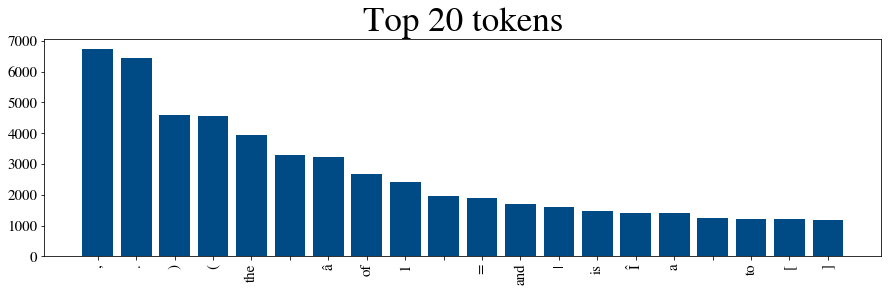

In [23]:
tokens_list = []
tok_list = []
doc_list = []
i = 0
for fdata in filedata:
    doc = metapy.index.Document()
    doc.content(filedata[i])
    doc_list.append(doc)
    tok = metapy.analyzers.ICUTokenizer(suppress_tags=True)
    tok.set_content(doc.content())
    tok_list.append(tok)
    tokens = [token for token in tok]
    tokens_list.append(tokens)
    i += 1
all_tokens = [j for i in tokens_list for j in i]
# Graph top 20 tokens
graph(all_tokens)

In [24]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,39496,39497,39498,39499,39500,39501,39502,39503,39504,39505
0,Smooth,ReÌ,,nyi,Entropy,of,Ergodic,Quantum,Information,Sources,...,None,None,None,None,None,None,None,None,None,None
1,Analyzing,Design,Process,and,Experiments,on,the,AnITA,Generic,Tutoring,...,None,None,None,None,None,None,None,None,None,None
2,1,Colour,Image,Segmentation,by,the,Vector,-,valued,Allen,...,None,None,None,None,None,None,None,None,None,None
3,1,Unequal,Error,Protection,:,An,Information,Theoretic,Perspective,arXiv,...,6,),:,729â,,,733,",",1979,.
4,On,the,hitting,times,of,quantum,versus,random,walks,â,...,None,None,None,None,None,None,None,None,None,None
5,arXiv,:,0811.1254v1,[,math.CO,],8,Nov,2008,Chapter,...,None,None,None,None,None,None,None,None,None,None
6,Generating,Random,Networks,Without,Short,Cycles,Mohsen,Bayati,Graduate,School,...,None,None,None,None,None,None,None,None,None,None
7,1,Variations,on,a,theme,by,Schalkwijk,and,Kailath,Robert,...,None,None,None,None,None,None,None,None,None,None


## 6.2. Remoción de caracteres especiales <a name="c_remo_car"></a>

BOW size =  7176


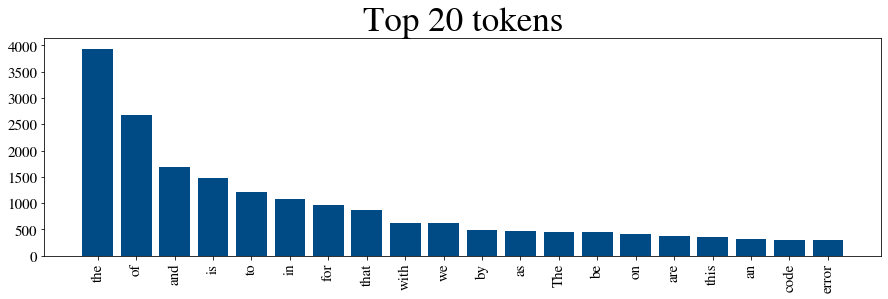

In [25]:
i = 0
for tok in tok_list:
    tok = metapy.analyzers.LengthFilter(tok, min=2, max=30)
    tok.set_content(doc_list[i].content())
    tok_list[i] = tok
    tokens = [token for token in tok]
    tokens_list[i] = tokens
    i += 1
all_tokens = [j for i in tokens_list for j in i]
# Graph top 20 tokens
graph(all_tokens)

In [26]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,18443,18444,18445,18446,18447,18448,18449,18450,18451,18452
0,Smooth,ReÌ,nyi,Entropy,of,Ergodic,Quantum,Information,Sources,Berry,...,None,None,None,None,None,None,None,None,None,None
1,Analyzing,Design,Process,and,Experiments,on,the,AnITA,Generic,Tutoring,...,None,None,None,None,None,None,None,None,None,None
2,Colour,Image,Segmentation,by,the,Vector,valued,Allen,Cahn,Phase,...,None,None,None,None,None,None,None,None,None,None
3,Unequal,Error,Protection,An,Information,Theoretic,Perspective,arXiv,0803.2570v4,cs.IT,...,feedback,IEEE,Transactions,on,Information,Theory,25,729â,733,1979
4,On,the,hitting,times,of,quantum,versus,random,walks,arXiv,...,None,None,None,None,None,None,None,None,None,None
5,arXiv,0811.1254v1,math.CO,Nov,2008,Chapter,Coding,theory,and,algebraic,...,None,None,None,None,None,None,None,None,None,None
6,Generating,Random,Networks,Without,Short,Cycles,Mohsen,Bayati,Graduate,School,...,None,None,None,None,None,None,None,None,None,None
7,Variations,on,theme,by,Schalkwijk,and,Kailath,Robert,Gallager,BarÄ,...,None,None,None,None,None,None,None,None,None,None


## 6.3. Stopwords <a name="c_stwd"></a>

BOW size =  6927


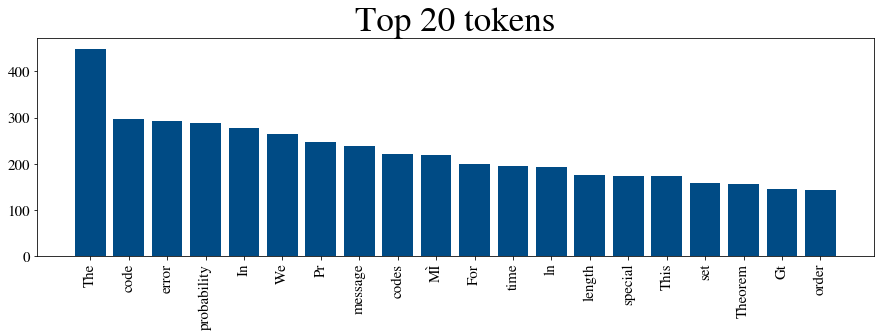

In [27]:
i = 0
for tok in tok_list:
    tok = metapy.analyzers.ListFilter(tok, "lemur-stopwords.txt", metapy.analyzers.ListFilter.Type.Reject)
    tok.set_content(doc_list[i].content())
    tok_list[i] = tok
    tokens = [token for token in tok]
    tokens_list[i] = tokens
    i += 1

all_tokens = [j for i in tokens_list for j in i]
# Graph top 20 tokens
graph(all_tokens)

In [28]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,12002,12003,12004,12005,12006,12007,12008,12009,12010,12011
0,Smooth,ReÌ,nyi,Entropy,Ergodic,Quantum,Information,Sources,Berry,Schoenmakers,...,None,None,None,None,None,None,None,None,None,None
1,Analyzing,Design,Process,Experiments,AnITA,Generic,Tutoring,System,Matthias,BRUST,...,None,None,None,None,None,None,None,None,None,None
2,Colour,Image,Segmentation,Vector,valued,Allen,Cahn,Phase,field,Model,...,None,None,None,None,None,None,None,None,None,None
3,Unequal,Error,Protection,An,Information,Theoretic,Perspective,arXiv,0803.2570v4,cs.IT,...,noiseless,feedback,IEEE,Transactions,Information,Theory,25,729â,733,1979
4,On,hitting,times,quantum,versus,random,walks,arXiv,0808.0084v1,quant,...,None,None,None,None,None,None,None,None,None,None
5,arXiv,0811.1254v1,math.CO,Nov,2008,Chapter,Coding,theory,algebraic,combinatorics,...,None,None,None,None,None,None,None,None,None,None
6,Generating,Random,Networks,Without,Short,Cycles,Mohsen,Bayati,Graduate,School,...,None,None,None,None,None,None,None,None,None,None
7,Variations,theme,Schalkwijk,Kailath,Robert,Gallager,BarÄ,sÌ,NakibogÌ,lu,...,None,None,None,None,None,None,None,None,None,None


## 6.4. Stemming <a name="c_stem"></a>

BOW size =  5493


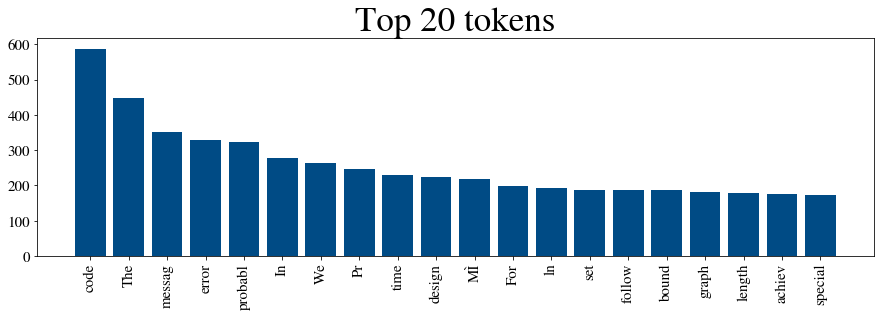

In [29]:
i = 0
for tok in tok_list:
    tok = metapy.analyzers.Porter2Filter(tok)
    tok.set_content(doc_list[i].content())
    tok_list[i] = tok
    tokens = [token for token in tok]
    tokens_list[i] = tokens
    i += 1

all_tokens = [j for i in tokens_list for j in i]
# Graph top 20 tokens
graph(all_tokens)

In [30]:
pd.DataFrame(tokens_list)

,0,1,2,3,4,5,6,7,8,9,...,12002,12003,12004,12005,12006,12007,12008,12009,12010,12011
0,Smooth,ReÌ,nyi,Entropi,Ergodic,Quantum,Informat,Sourc,Berri,Schoenmak,...,None,None,None,None,None,None,None,None,None,None
1,Analyz,Design,Process,Experiment,AnITA,Gener,Tutor,System,Matthia,BRUST,...,None,None,None,None,None,None,None,None,None,None
2,Colour,Image,Segment,Vector,valu,Allen,Cahn,Phase,field,Model,...,None,None,None,None,None,None,None,None,None,None
3,Unequal,Error,Protect,An,Informat,Theoret,Perspect,arXiv,0803.2570v4,cs.IT,...,noiseless,feedback,IEEE,Transact,Informat,Theori,25,729â,733,1979
4,On,hit,time,quantum,versus,random,walk,arXiv,0808.0084v1,quant,...,None,None,None,None,None,None,None,None,None,None
5,arXiv,0811.1254v1,math.CO,Nov,2008,Chapter,Code,theori,algebra,combinator,...,None,None,None,None,None,None,None,None,None,None
6,Gener,Random,Network,Without,Short,Cycl,Mohsen,Bayati,Graduat,School,...,None,None,None,None,None,None,None,None,None,None
7,Variat,theme,Schalkwijk,Kailath,Robert,Gallag,BarÄ,sÌ,NakibogÌ,lu,...,None,None,None,None,None,None,None,None,None,None


In [31]:
#save tokens od this metodology to rank_bm25 algorithm
token_list_bm25 = tokens_list.copy()

## 6.5. Tokenización en ngrams  <a name="c_token_ng"></a>

In [32]:
i = 0
for tok in tok_list:
    tok = metapy.analyzers.ICUTokenizer(suppress_tags=True)
    tok = metapy.analyzers.LowercaseFilter(tok)
    tok.set_content(doc_list[i].content())
    tok_list[i] = tok
    tokens = [token for token in tok]
    tokens_list[i] = tokens

In [33]:
bigrams_list = []
for tok in tok_list:
    ana = metapy.analyzers.NGramWordAnalyzer(2, tok)
    bigrams_list.append(ana.analyze(doc))
bigrams = [j for i in bigrams_list for j in i]
bigrams

[('yi', '.'),
 ('3', 's1'),
 ('is', 'also'),
 ('boosting', 'reliability'),
 ('automatic', 'repeat'),
 ('this', 'lower'),
 ('m', 'into'),
 ('substituting', 'c'),
 (')', '\x11'),
 ('58', ')'),
 ('=', 's1'),
 ('=', 'nr'),
 ('it', 'follows'),
 ('given', 'sì'),
 ('not', 'only'),
 ('first', 'transmitted'),
 (',', 'jun'),
 ('signals', 'are'),
 (')', 'nor'),
 ('transmissions', ','),
 ('when', 'expressed'),
 ('later', '.'),
 ('overall', 'power'),
 ('will', 'have'),
 ('regime', ','),
 ('in', '1'),
 ('n', '\x15'),
 ('new', 'york'),
 ('of', 'sì'),
 ('abstract', 'schalkwijk'),
 ('and', 'used'),
 ('bound', 'by'),
 ('the', 'transmit'),
 ('simplified', 'by'),
 ('power', 'constraint'),
 ('is', 'tutorial'),
 ('electronics', ','),
 ('second', ','),
 ('of', 'feedback'),
 ('\x92', '3â'),
 ('\x9a', 'diâ'),
 ('expected', 'delay'),
 ('1', 'for'),
 ('râ', '\x88'),
 ('spaced', 'm'),
 ('converse', 'of'),
 ('note', 'that'),
 ('(', '('),
 ('tentative', 'ml'),
 ('0.12', '.'),
 ('quantities', 'as'),
 ('quadratically

In [34]:
trigrams_list = []
for tok in tok_list:
    ana = metapy.analyzers.NGramWordAnalyzer(3, tok)
    trigrams_list.append(ana.analyze(doc))
trigrams = [j for i in trigrams_list for j in i]
trigrams

[('notational', 'device', 'throughout'),
 ('initial', 'channel', 'input'),
 (',', 'if', 'z'),
 ('same', 'technique', 'can'),
 ('minimizing', 'the', 'error'),
 ('strategy', 'at', 'times'),
 ('3', ']', 'm'),
 ('to', 'the', 'second'),
 ('iterating', 'on', 'equation'),
 ('to', 'be', 'an'),
 ('4', 'are', 'somewhat'),
 ('error', 'is', 'bounded'),
 ('ns', '+', 'n1'),
 ('faster', 'than', 'linearly'),
 ('mathematics', 'of', 'the'),
 ('/', '6', '1'),
 ('quantization', 'of', 'yi'),
 (')', '.', '12'),
 ('an', 'exponential', 'order'),
 ('on', 'its', 'mean'),
 ('above', 'bound', 'is'),
 ('than', 'a', 'discrete'),
 ('-', 'pam', ','),
 ('replacing', 'the', 'coefficient'),
 ('is', 'the', 'mean'),
 ('rapid', 'decrease', 'of'),
 ('dimensional', 'channel', 'input'),
 ('as', 'in', 'the'),
 ('n1', '.', 'we'),
 ('this', 'restriction', ','),
 ('as', 'estimating', 'z0'),
 (',', 'this', 'scheme'),
 ('of', '(', '38'),
 ('is', 'quite', 'different'),
 ('of', 'm', 'into'),
 ('2', '2', '['),
 ('we', 'assumed', 'that

<a name="repre"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">7. Representación de características y de documentos</font></h1>

Investigar en cada una de las librerías diferentes opciones de representación de características como one-bit, TF, TF-IDF, BM25, word2vec, doc2vec.
<hr style="border:1px solid black"> </hr>

## 7.1. rank_bm25 <a name="bm25"></a>

[Link](https://docs.vespa.ai/en/reference/bm25.html)

The [bm25 rank feature](https://docs.vespa.ai/en/reference/rank-features.html#bm25) implements the [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25) ranking function used to estimate the relevance of a text document given a search query. It is a pure text ranking feature which operates over an indexed string field. The feature is very cheap to compute, about 3-4 times faster than nativeRank, while still providing a good rank score quality wise. It is a good candidate to use in a first phase ranking function when ranking text documents.

The bm25 feature calculates a score for how good a query with terms q1,...,qn matches an indexed string field t in a document D. The score is calculated as follows:

<a><img src="..\Images\bm251.png" width="500" align="center"></a>

Where the components in the function are:

- IDF(qi) : The inverse document frequency (IDF) of query term i in field t. This is calculated as:

<a><img src="..\Images\bm252.png" width="300" align="center"></a>

N is the total number of documents on the content node. n(qi) is the number of documents containing query term i for field t, which is calculated per index existing for that field. The max value among the indexes is used in the calculation, which typically comes from the largest [disk index](https://docs.vespa.ai/en/proton.html#index).

As the IDF is calculated per content node and index, slight variations might occur. To use the same IDF across all content nodes, set it as the significance on each query term using annotations.

- f(qi,D): The number of occurrences (term frequency) of query term i in the field t of document D. For multi-value fields we use the sum of occurrences over all elements.
- field_len: The field length (in number of words) of field t in document D. For multi-value fields we use the sum of field lengths over all elements.
- avg_field_len: The average field length of field t among the documents on the content node.
- k1: A parameter used to limit how much a single query term can affect the score for document D. With a higher value the score for a single term can continue to go up relatively more when more occurrences for that term exists. Default value is 1.2. Can be configured using rank-properties.
- b: A parameter used to control the effect of the field length of field t compared to the average field length. Default value is 0.75. Can be configured using rank-properties.

In [39]:
def tokenize_query(query):
    '''
    Function to tokenize teh query before search.
    (using metapy metod)
    
    Parameters
    ----------
    query:  string of words separated by spaces,
            input by the user.
    '''
    #tokenize
    doc = metapy.index.Document()
    doc.content(query)
    tok = metapy.analyzers.ICUTokenizer(suppress_tags=True)
    tok.set_content(doc.content())
    # special charcters
    tok = metapy.analyzers.LengthFilter(tok, min=2, max=30)
    tok.set_content(doc.content())
    #stopwords
    tok = metapy.analyzers.ListFilter(tok, "lemur-stopwords.txt", metapy.analyzers.ListFilter.Type.Reject)
    tok.set_content(doc.content())
    #stemming
    tok = metapy.analyzers.Porter2Filter(tok)
    tok.set_content(doc.content())
    #extract tokens
    tokens = [token for token in tok]
    return tokens
    
#tokens = tokenize_query('code in peace, say no to entropy in programming')  #function test
#print(tokens)

In [40]:
tokenized_corpus = token_list_bm25 #take the tokenised documents to run the bm25
bm25 = BM25Okapi(tokenized_corpus) #fit the model
print(colored('the input the key words to search the documents related to the topics','red')) #ask the user for the query
query = input(colored('User Query string :','red'))
tokenized_query = list(tokenize_query(query)) #tokenize the user query
doc_scores = bm25.get_scores(tokenized_query) # scores document base on query
doc_order = np.flip(np.argsort(doc_scores)) #organize by ranking

#get names of the documents
doc_order_name = []
for i in doc_order:
    doc_order_name.append(files[i])

#place results into DataFrame
ordered_documents = pd.DataFrame()
ordered_documents['Index Documento'] = doc_order
ordered_documents['Nombre Documento'] = doc_order_name
ordered_documents['Ranking'] = np.flip(np.sort(doc_scores))
ordered_documents.set_index('Index Documento')
ordered_documents

the input the key words to search the documents related to the topics
User Query string :code in peace, ay no to entropy in programming


,Index Documento,Nombre Documento,Ranking
0,1,0706.1402.txt,1.646407
1,5,0811.1254.txt,1.605525
2,3,0803.2570.txt,1.567866
3,7,0812.2709.txt,1.454066
4,0,0704.3504.txt,1.114974
5,2,0710.0736.txt,0.882288
6,6,0811.2853.txt,0.641029
7,4,0808.0084.txt,0.000000


## 7.2. Scikit-Learn <a name="sk"></a>

### TF-IDF
[Link libreria](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

Una pregunta típica es de qué trata ese documentos o texto?
Una medida de cuán importante es una palabra en un documento puede ser la frecuencia de ella, como la hemos medido hasta ahora. A esto se le conoce como term frequency (tf).

<a><img src="..\Images\tf.png" width="800" align="center"></a>

Es posible que una palabra sea más importante en un documentos que en otro, cuando estamos analizando varios documentos.
La técnica de stop-words es buena para eliminar las palabras comunmente usadas en un lenguaje. Cuando necesitamos llevar las palabras a una medida numérica, además de la TF, otra técnica, cuando trabajamos con diferentes documentos, es la conocida como frecuencia inversa de documentos (idf), que disminuye el peso para palabras comunes y le da mayor peso a las que no son comunmente usadas en una colección de documentos (colección de novelas, o colección de sitios web).

<a><img src="..\Images\idf.png" width="800" align="center"></a>

Pero el término que nos va a dar la importancia de los términos en un documento que hace parte de una colección es el tf_idf.

TF-IDF (siglas de Término-Frecuencia-Frecuencia de Documento Inverso) pondera las palabras comunes que ocurren en casi todos los documentos y le da más importancia a las palabras que aparecen en un subconjunto de documentos. TF-IDF funciona penalizando estas palabras comunes asignándoles pesos más bajos y dando importancia a algunas palabras raras en un documento en particular.

<a><img src="..\Images\tfidf.png" width="950" align="center"></a>

In [35]:
tv = TfidfVectorizer(token_pattern=r'(?u)\b[A-Za-z]+\b',
                     sublinear_tf=True,
                     stop_words='english', ngram_range=(1,1),) #in this case we run the model only with letters not numbers
model_tv = tv.fit_transform(filedata)
df_model = pd.DataFrame(model_tv.toarray(),columns=tv.get_feature_names())
print(colored('Shape: ','red'), df_model.shape)
df_model

Shape:  (8, 4655)


,aaronson,aat,abelian,aber,abh,abilities,ability,able,abn,abovementioned,...,zheng,zi,ziegler,zigangirov,zihz,zinoviev,zn,zu,zwei,zyablov
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037238,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052841,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021592,0.069034,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.025811,0.000000,0.000000,0.000000,0.000000,0.015245,0.000000,0.000000,0.000000,0.015245
4,0.022966,0.000000,0.022966,0.000000,0.000000,0.000000,0.000000,0.045930,0.038885,0.000000,...,0.000000,0.075847,0.000000,0.000000,0.022966,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.048566,0.000000,0.016486,0.027913,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.016486,0.000000,0.000000,0.000000,0.000000,0.016486,0.016486,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.017687,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018485,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.057555,0.000000,0.000000,0.018485,0.000000,0.000000,0.000000


## 7.3. Gensim <a name="gensim"></a>

### BM-25
[Link Libreria](https://www.kite.com/python/docs/gensim.summarization.bm25.BM25)

[Teoria](https://es.wikipedia.org/wiki/Okapi_BM25)

In [36]:
query = input(colored('enter your search: '))

texts = [doc.split() for doc in filedata]
#texts = filedata
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
bm25_obj = bm25_gensim.BM25(corpus)
query_doc = dictionary.doc2bow(query.split())
scores = bm25_obj.get_scores(query_doc)
best_docs = sorted(range(len(scores)), key=lambda i: scores[i])[-5:]

enter your search: code


In [37]:
best_docs

[3, 4, 5, 7, 6]

In [38]:
scores

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.410783732962444, 0.0]

## 7.4. pySpark <a name="pyspark"></a>

## 7.5. Metapy <a name="metapy"></a>

<a name="otros"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">8. Otros Ejemplos</font></h1>
<hr style="border:1px solid black"> </hr>

Otros ejemplos y demos pueden ser encontrados en el [github de la materia](https://github.com/st1800eafit/st1800_20211.git) y muchos foros de comunidad:
- [Data Science Central](https://www.datasciencecentral.com/)
- [Towards data science](https://towardsdatascience.com/)
- [Kaggle](https://www.kaggle.com/)
- [Medium Daily Digest NLP](https://medium.com/@ODSC/an-introduction-to-natural-language-processing-nlp-8e476d9f5f59)

<a name="crit_eval"></a><hr style="border:1px solid black"> </hr>
<h1 align="center"><font size="6">9. Criterios de evaluación</font></h1>
<hr style="border:1px solid black"> </hr>

Se tendrán en cuenta los siguientes porcentajes de evaluación de cada una de las partes:

| Item | Porcentaje |
| :- | -: |
| Text Prep, Rep características y docs en Python y librerías relacionadas | 40% |
| Text Prep, Rep características y docs en PySpark con las librerías de SparkML de NLP y Text Mining | 40% |
| Text Prep, Rep características y docs en metapy | 20% |